In [1]:
import anndata as ad
import scanpy as sc
import scvi
import muon as mu
import os
import pandas as pd
import numpy as np
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import useful_functions as uf
import sys
print(sys.executable)
import torch
import gdown
import warnings

#warnings
warnings.simplefilter(action='ignore')
#figures
sc.set_figure_params(frameon=False, figsize=(4, 4), dpi=100)
#set seeds for reproducibility
scvi.settings.seed = 100
#torch
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

Global seed set to 0
/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


/nfs/team297/bs16/tools/conda_envs/scvi-env/bin/python3.9


Global seed set to 100


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(scvi.__version__)
print(pd.__version__)
print(np.__version__)
print(mu.__version__)


1.9.1
0.8.0
0.19.0
1.5.1
1.23.5
0.1.2


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
rna_multiome_adata = sc.read_h5ad("data/raw/10X_multiome/multiome_rna_raw.h5ad")
atac_multiome_adata = sc.read_h5ad("data/raw/10X_multiome/multiome_atac_raw.h5ad")


In [4]:
#do donor map to get donors rather than genotypes (re pairs)
donor_map = {"GPD1" : "GPD1", "K232" : "K232", "K241" : "K241", "K245":"K245" , "K247" : "K247",
                 "K250" : "K250_K251",  "K251" : "K250_K251", "K254" : "K254", "K255" : "K255",
                 "K257" : "K257", "K260" : "K260", "K262" : "K262", "K269" : "K269",
                 "K270" : "K270", "K271" : "K271", "K272" : "K272", "K273" : "K273",  
                 "K275" : "K275", "K277" : "K277", "K278" : "K278", "K294" : "K294", 
                 "TXN10-donor" : "TXN10", "TXN10-recipient" : "TXN10"}
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
rna_multiome_adata.obs['donor'] = rna_multiome_adata.obs['genotype'].map(donor_map).astype('category')
atac_multiome_adata.obs['donor'] = rna_multiome_adata.obs['genotype'].map(donor_map).astype('category')

In [5]:
#MULTIOME DOUBLETS
#get doublet droplets from four methods 1) genotype demultiplexing 2) transcriptome prediction 3) AMULET 4) weighted from genotype demultiplexing
print(rna_multiome_adata.shape)

from functools import reduce
rna_genocut = rna_multiome_adata.obs['status'].isin(["doublet"])
rna_dblcut = rna_multiome_adata.obs['dblf_cuts'].isin(["doublet"])
rna_gt_predict =  rna_multiome_adata.obs['dblf_genotype_predicted'].isin(['doublet'])
rna_dbl_weighted = rna_multiome_adata.obs['dblf_weighted'] > 0.6
atac_amucut = atac_multiome_adata.obs['amulet_doublet'] == True

doublet_drops = reduce(np.union1d, 
                    (
                        [
                            np.array(rna_multiome_adata.obs_names[rna_genocut]), 
                            np.array(rna_multiome_adata.obs_names[rna_dblcut]), 
                            np.array(atac_multiome_adata.obs_names[atac_amucut]),
                            np.array(rna_multiome_adata.obs_names[rna_gt_predict]),
                            np.array(rna_multiome_adata.obs_names[rna_dbl_weighted])
                        ]
                    )
                   )
doublet_drops = np.unique(doublet_drops)
#remove the doublet droplets
rna_multiome_adata = rna_multiome_adata[~rna_multiome_adata.obs_names.isin(doublet_drops)]
atac_multiome_adata = atac_multiome_adata[~atac_multiome_adata.obs_names.isin(doublet_drops)]

print(rna_multiome_adata.shape)

(78570, 36601)
(61576, 36601)


In [6]:
#find barcodes which are common to atac and rna adata and subset
common_barcodes = np.intersect1d(rna_multiome_adata.obs_names.values, 
               atac_multiome_adata.obs_names.values)
#subset
rna_multiome_adata = rna_multiome_adata[common_barcodes]
atac_multiome_adata = atac_multiome_adata[common_barcodes]

In [7]:
#rna highly variable 
sc.pp.highly_variable_genes(rna_multiome_adata, layer = 'counts', n_top_genes = 3000, 
                           subset = False, flavor = 'seurat_v3')
#scvi.data.poisson_gene_selection(rna_multiome_adata, layer='counts', n_top_genes=3000, use_gpu=True, subset=True, inplace=True, n_samples=10000, batch_key=None, silent=False, minibatch_size=5000)
print(rna_multiome_adata.shape)
rna_features = np.array(rna_multiome_adata.var_names[rna_multiome_adata.var['highly_variable']])

(55360, 36601)


In [8]:
#normalise and log transform the RNA data
sc.pp.normalize_total(rna_multiome_adata, target_sum=1e4)
sc.pp.log1p(rna_multiome_adata)

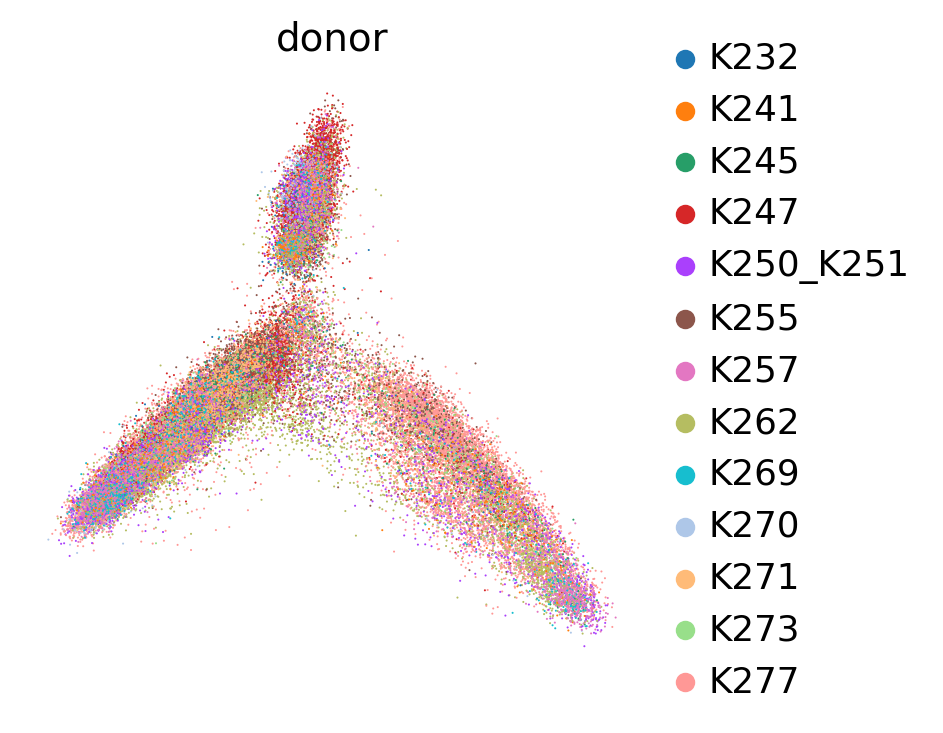

In [9]:
#do PCA on these data
sc.pp.pca(rna_multiome_adata)
sc.pl.pca(rna_multiome_adata, color = 'donor')

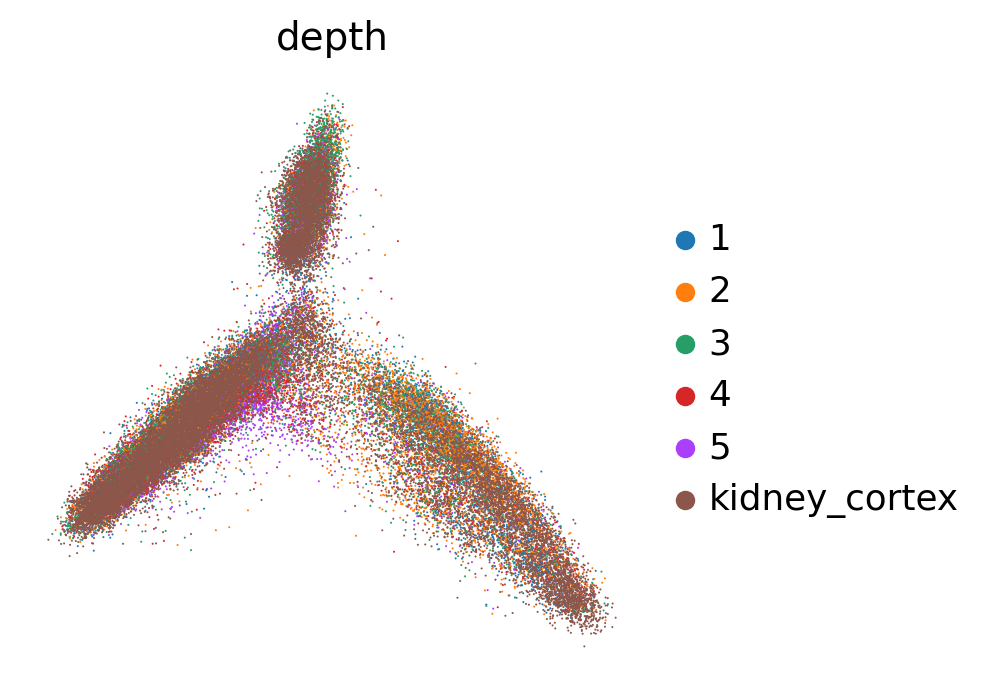

In [10]:
sc.pl.pca(rna_multiome_adata, color = 'depth')

In [11]:
#some pp atac adata and subset to detectable regions
atac_multiome_adata.layers['counts'] = atac_multiome_adata.X

#subset some atac multiome adata
print(atac_multiome_adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(atac_multiome_adata.shape[0] * 0.05)
sc.pp.calculate_qc_metrics(atac_multiome_adata)
atac_multiome_adata.var['peak_keep'] = atac_multiome_adata.var['n_cells_by_counts'] > min_cells


(55360, 1049261)


In [12]:
#get the union of peaks to keep and subset them
atac_multiome_peaks = np.array(atac_multiome_adata.var_names[atac_multiome_adata.var['peak_keep']])
peakset = atac_multiome_peaks
print(peakset.shape)

(54272,)


In [13]:
#set the feature types
rna_multiome_adata.var['feature_types'] = 'Gene Expression'
atac_multiome_adata.var['feature_types'] = 'Peaks'

In [14]:
#generate an integrated adata object for the multiome data
multiome_adata = sc.concat([rna_multiome_adata, atac_multiome_adata], axis = 1)

In [15]:
#add the obs we lost
multiome_adata.obs = pd.concat([multiome_adata.obs, rna_multiome_adata.obs], axis = 1)

In [16]:
#make an adata for input to multiVI
adata_mvi = scvi.data.organize_multiome_anndatas(multi_anndata = multiome_adata)

In [17]:
#randomly sample
#sampled_barcodes = np.random.choice(np.array(adata_mvi.obs_names), 5000, replace = False)
#adata_mvi = adata_mvi[sampled_barcodes]

In [18]:
#save to raw
adata_mvi.uns['raw_adata'] = adata_mvi.copy() #this lets us get the rawcounts later

In [19]:
#make raw (useful for later)
adata_mvi.raw = adata_mvi.copy()

In [20]:
#subset to relevant genes and peaks
all_features = peakset = np.union1d(rna_features, peakset)
adata_mvi = adata_mvi[:, all_features]

In [21]:
#set these for later how we like them
adata_mvi.var['Symbol'] = adata_mvi.var['ID'] = np.array(adata_mvi.var_names)

In [22]:
#how much of each modality do we have
adata_mvi.obs['modality'].value_counts()

paired    55360
Name: modality, dtype: int64

In [23]:
#set up the adata for the model
scvi.model.MULTIVI.setup_anndata(adata_mvi, layer = 'counts', 
                                batch_key = 'donor')

In [24]:
#set up the model
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["feature_types"] == "Gene Expression").sum(),
    n_regions=(adata_mvi.var["feature_types"] == "Peaks").sum()    
)
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'donor',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  13   │
│         n_cells          │ 55360 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 57272 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor'] │    K232    │          0          │
│                    │    K241    │          1          │
│                    │    K245    │          2          │
│                    │    K247    │          3          │
│                    │ K250_K251  │          4          │
│                    │    K255    │          5          │
│                    │    K257    │          6          │
│                    │    K262    │          7          │
│                    │    K269    │          8          │
│                    │    K270    │          9          │
│                    │    K271    │         10          │
│                    │    K273    │         11          │
│                    │    K277    │         12          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor'] │    K232    │          0          │
│                    │    K241    │          1          │
│                    │    K245    │          2          │
│                    │    K247    │          3          │
│                    │ K250_K251  │          4          │
│                    │    K255    │          5          │
│                    │    K257    │          6          │
│                    │    K262    │          7          │
│                    │    K269    │          8          │
│                    │    K270    │          9          │
│                    │    K271    │         10          │
│                    │    K273    │         11          │
│                    │    K277    │         12          │
└────────────────────┴────────────┴─────────────────────┘

In [25]:
#train the model
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 113/500:  23%|█████████▍                                | 113/500 [2:24:07<8:13:36, 76.53s/it, loss=6.06e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 12753.915. Signaling Trainer to stop.


In [26]:
#get a latent representation
adata_mvi.obsm["X_mVI"] = mvi.get_latent_representation()

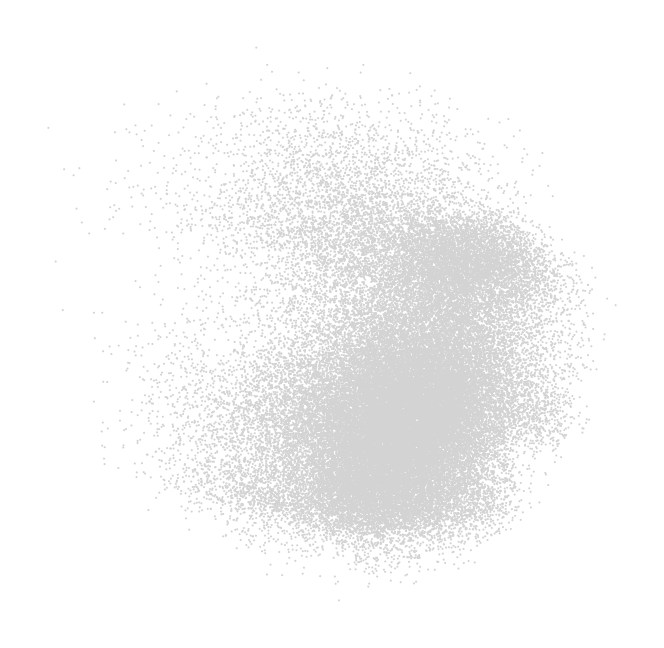

In [27]:
#plot the integrated embedding
sc.pl.embedding(adata_mvi ,basis = "X_mVI")

In [28]:
#save
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/trained/10X_multiome')
mvi.save("multivi_atlas_model/", overwrite=True, save_anndata = True)